In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from PIL import Image

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/kaggle')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!kaggle datasets download -d jessicali9530/celeba-dataset
os.chdir('/content')
!cp '/content/drive/MyDrive/kaggle/celeba-dataset.zip' .
!unzip -q 'celeba-dataset.zip'

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
SEED = 42
BEST_EPOCH = 14

IMG_SIZE = 64
BATCH_SIZE = 256

BEST_MODEL_SAVE_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration/best_model.tf'
VIDEOS_SAVE_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration/'

LOG_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration/training_log.csv'

RECONSTRUCTION_IMAGES_SAVE_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration/Reconstructions'
GENERATED_IMAGES_SAVE_PATH = '/content/drive/MyDrive/ML_DL/FaceGeneration/Generated'

In [ ]:
random.seed(SEED)

partition_df = pd.read_csv('/content/list_eval_partition.csv')
partition_df['partition'] = partition_df['partition'].replace({0: 'train'})
partition_df['partition'] = partition_df['partition'].replace({1: 'validation'})
partition_df['partition'] = partition_df['partition'].replace({2: 'test'})

test_df = partition_df[partition_df['partition'] == 'test']

VAE = load_model(BEST_MODEL_SAVE_PATH)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255.)

test_generator = datagen.flow_from_dataframe(
  dataframe=test_df,
  directory='/content/img_align_celeba/img_align_celeba',
  x_col='image_id',
  y_col=None,
  target_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  class_mode=None,
  shuffle=True,
  seed=SEED,
  interpolation="bilinear",
)

Found 19962 validated image filenames.


In [ ]:
def read_images_from_directory(directory_path):
  images = []
  for filename in os.listdir(directory_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img = Image.open(os.path.join(directory_path, filename))
      if img is not None:
        images.append(img)
  return images

reconstrucion_images = read_images_from_directory(RECONSTRUCTION_IMAGES_SAVE_PATH)[:BEST_EPOCH]
generated_images = read_images_from_directory(GENERATED_IMAGES_SAVE_PATH)[:BEST_EPOCH]

In [ ]:
def create_video_from_images(images, output_path, fps=1):
  width, height = images[0].size

  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

  for image in images:
    cv2_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    out.write(cv2_image)

  out.release()
  cv2.destroyAllWindows()

create_video_from_images(reconstrucion_images, f'{VIDEOS_SAVE_PATH}/reconstructions.mp4')
create_video_from_images(generated_images, f'{VIDEOS_SAVE_PATH}/generated.mp4')

In [ ]:
num_steps = np.ceil(test_generator.samples / test_generator.batch_size)
encoded_images = []

for i in range(int(num_steps)):
  batch = next(test_generator)

  z_mean, _, _ = VAE.encoder.predict(batch, verbose=0)
  encoded_images.append(z_mean)

encoded_images = np.concatenate(encoded_images, axis=0)

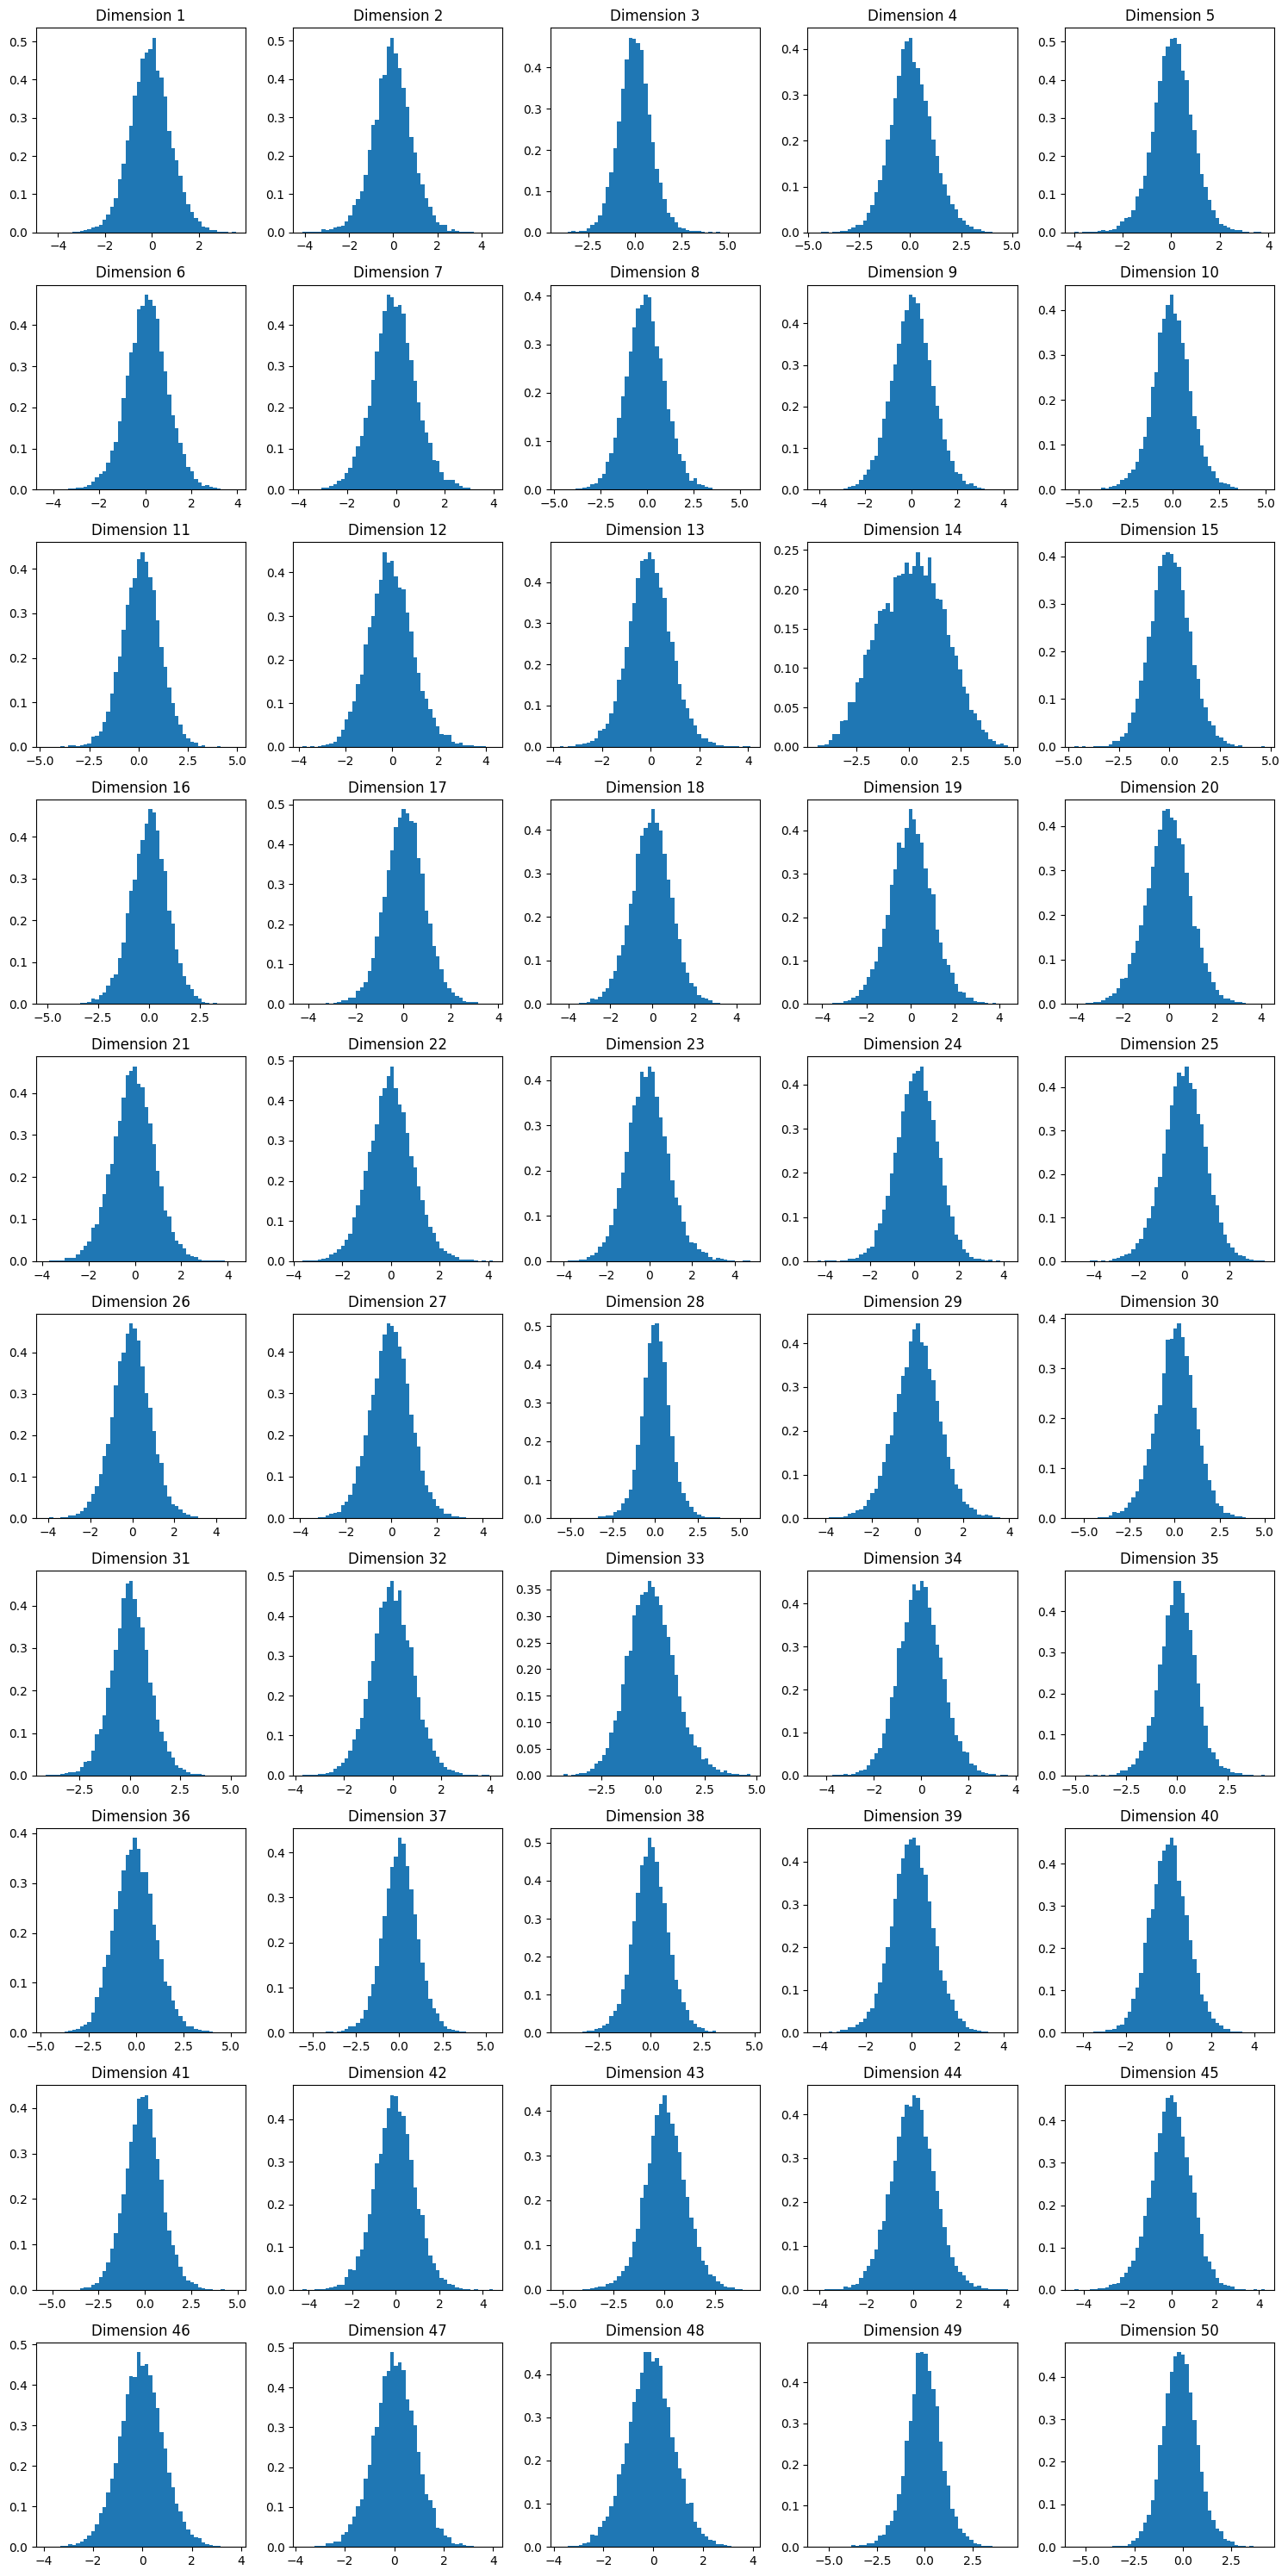

In [ ]:
def plot_latent_distribution(encoded_images, num_dimensions=50):
  selected_dimensions = encoded_images[:, :num_dimensions]

  fig, axs = plt.subplots(10, 5, figsize=(15, 30))
  axs = axs.ravel()

  for i in range(num_dimensions):
    axs[i].hist(selected_dimensions[:, i], bins=50, density=True)
    axs[i].set_title(f'Dimension {i+1}')

  plt.tight_layout()
  plt.show()

plot_latent_distribution(encoded_images)

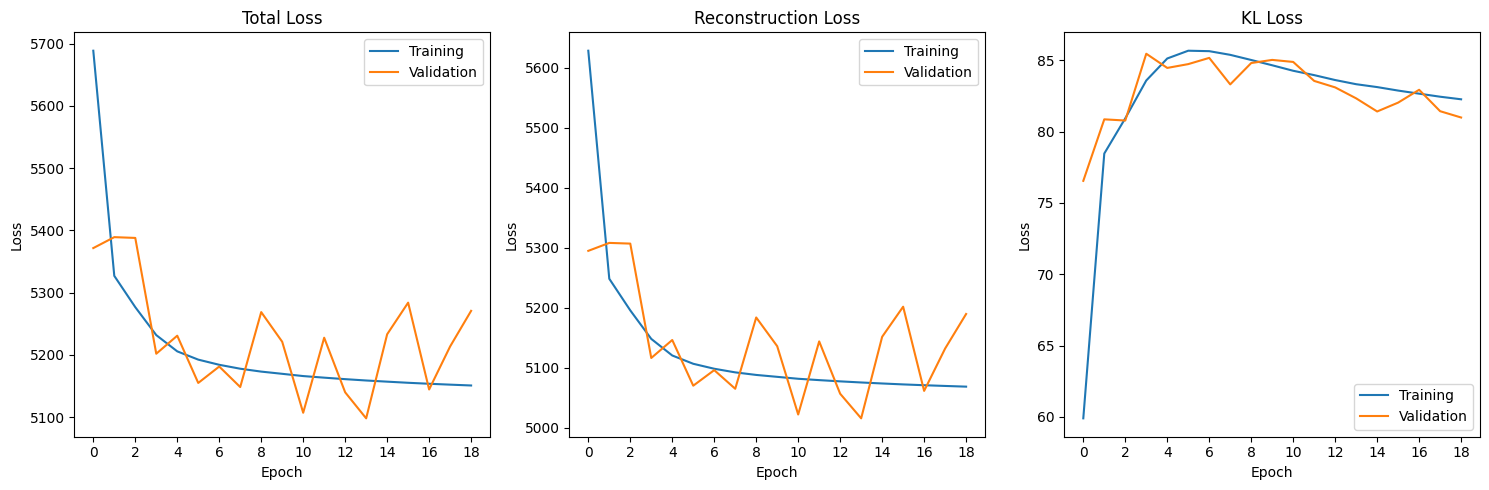

In [53]:
logs = pd.read_csv(LOG_PATH, sep=';')

plt.figure(figsize=(15, 5))

# Plot total loss
plt.subplot(1, 3, 1)
plt.plot(logs['total_loss'], label='Training')
plt.plot(logs['val_loss'], label='Validation')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot reconstruction loss
plt.subplot(1, 3, 2)
plt.plot(logs['reconstruction_loss'], label='Training')
plt.plot(logs['val_reconstruction_loss'], label='Validation')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot KL loss
plt.subplot(1, 3, 3)
plt.plot(logs['kl_loss'], label='Training')
plt.plot(logs['val_kl_loss'], label='Validation')
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()